In [1]:
from sympy import cxxcode, init_printing, Matrix, S, symbols
from sympy.codegen.rewriting import create_expand_pow_optimization
from sympy.vector import CoordSys3D

init_printing()

### Generate Symbols

Symbols will be generated for: Earth's gravitational constant, Earth's angular rate in ECEF, the satellites position in ECEF, and the satellite's velocity in ECEF.

Vectors for all the above quantities are thenn created.

In [2]:
mu = symbols('mu')
wx, wy, wz = symbols('w_x w_y w_z')
rx, ry, rz, vx, vy, vz = symbols('r_x r_y r_z v_x v_y v_z')
mu, wx, wy, wz, rx, ry, rz, vx, vy, vz

In [3]:
ECEF = CoordSys3D('ECEF')

# Earth's angular rate
w = wx * ECEF.i + wy * ECEF.j + wz * ECEF.k

# Satellite position and velocity
r = rx * ECEF.i + ry * ECEF.j + rz * ECEF.k
v = vx * ECEF.i + vy * ECEF.j + vz * ECEF.k

### Define Acceleration Terms

Expressions are created for the various gravity terms and forces due to working in a nonintertial reference frame.

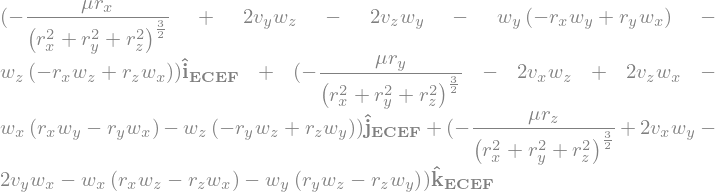

In [4]:
# Gravity terms
J0 = -mu * r / r.magnitude() ** S(3)

# Total acceleration
a = J0 - S(2) * w.cross(v) - w.cross(w.cross(r))
a

### Jacobian Calculation

The jacobian of time derivative of the state space representation is taken with respect to the state vector.

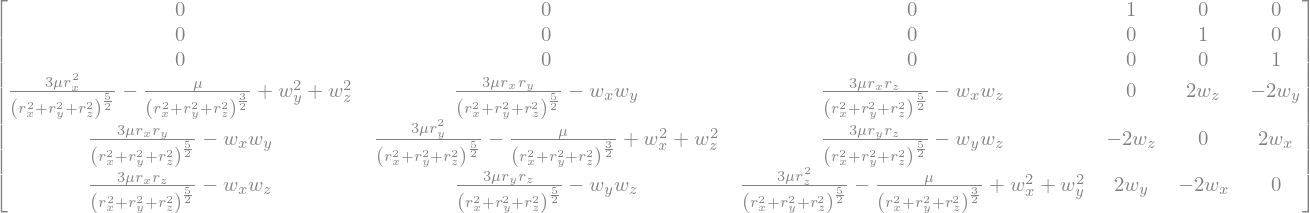

In [5]:
J = Matrix([v.to_matrix(ECEF), a.to_matrix(ECEF)]).jacobian([r.to_matrix(ECEF), v.to_matrix(ECEF)])
J

### Code Generation

The goal here is to create a code snippet that will be copy pasted into the orbit estimators source file. See `src/gnc/orbit.cpp` for more information.

In [6]:
nr, nr3, nr5 = symbols('nr nr3 nr5')

opt = create_expand_pow_optimization(5)

In [7]:
for i in range(J.rows):
    for j in range(J.cols):
        expr = J[i, j]
        expr = expr.subs(r.magnitude(), nr)
        expr = expr.subs(nr * nr * nr, nr3)
        expr = expr.subs(nr * nr * nr * nr * nr, nr5)
        if expr != S(0):
            print('  J({0}, {1}) = '.format(i, j) + cxxcode(opt(expr)) + ';')

  J(0, 3) = 1;
  J(1, 4) = 1;
  J(2, 5) = 1;
  J(3, 0) = -mu*1.0/nr3 + 3*mu*1.0/nr5*(r_x*r_x) + w_y*w_y + w_z*w_z;
  J(3, 1) = 3*mu*r_x*r_y*1.0/nr5 - w_x*w_y;
  J(3, 2) = 3*mu*r_x*r_z*1.0/nr5 - w_x*w_z;
  J(3, 4) = 2*w_z;
  J(3, 5) = -2*w_y;
  J(4, 0) = 3*mu*r_x*r_y*1.0/nr5 - w_x*w_y;
  J(4, 1) = -mu*1.0/nr3 + 3*mu*1.0/nr5*(r_y*r_y) + w_x*w_x + w_z*w_z;
  J(4, 2) = 3*mu*r_y*r_z*1.0/nr5 - w_y*w_z;
  J(4, 3) = -2*w_z;
  J(4, 5) = 2*w_x;
  J(5, 0) = 3*mu*r_x*r_z*1.0/nr5 - w_x*w_z;
  J(5, 1) = 3*mu*r_y*r_z*1.0/nr5 - w_y*w_z;
  J(5, 2) = -mu*1.0/nr3 + 3*mu*1.0/nr5*(r_z*r_z) + w_x*w_x + w_y*w_y;
  J(5, 3) = 2*w_y;
  J(5, 4) = -2*w_x;
